In [12]:
# Use to get any item from your google drive
from google.colab import drive
drive.mount('/content/drive')
![[ ! -f 490data.tar.gz ]] && cp /content/drive/My\ Drive/490data.tar.gz .
![[ ! -d data ]] && rm -rf ./data
!mkdir -p data
!tar -xvzf 490data.tar.gz -C .
!rm 490data.tar.gz

Mounted at /content/drive
./data/
./data/geocells_yfcc.csv
./data/yfcc_geocell_collection_new.npy
./data/geocells/
./data/geocells/countries.geojson
./data/geocells/admin_2.geojson
./data/geocells/admin_1.geojson
./data/geocells/admin_2.geojson_compressed_2.5.geojson
./data/geocells/countries.geojson_compressed_2.5.geojson
./data/geocells/admin_1.geojson_compressed_2.5.geojson


In [13]:
# This is supposed to make sure if you edit .py files
# colab will pick up on it
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
!if [[ ! -d PROJECT ]] && [[ ! -d PIGEON ]]; then git clone https://github.com/iggy2k/CSC490-Project-Winter-2025.git PROJECT; fi

In [15]:
import os
import sys

# Local
if os.path.isdir('PIGEON/'):
    PIGEON_DIR = 'PIGEON/'
# Git clone when colab
else:
    PIGEON_DIR = 'PROJECT/PIGEON/'

os.environ["PIGEON_DIR"] = PIGEON_DIR
sys.path.insert(1, PIGEON_DIR)

In [16]:
import yaml
from tqdm.notebook import tqdm
import subprocess


with open("./PROJECT/environment.yaml") as file_handle:
    environment_data = yaml.safe_load(file_handle)

for dependency in tqdm(environment_data["dependencies"], total=len(environment_data["dependencies"])):
    if isinstance(dependency, dict):
      for lib in tqdm(dependency['pip'], total=len(dependency['pip'])):
        try:
            out = subprocess.check_output(f'pip install {lib.split("=")[0]}', shell=True)
        except subprocess.CalledProcessError as err:
            print(err)
    else:
      try:
          subprocess.check_output(f'pip install {dependency.split("=")[0]}', shell=True)
      except subprocess.CalledProcessError as err:
          print(err)
try:
  subprocess.check_output('pip install pycountry global_land_mask', shell=True)
except subprocess.CalledProcessError as err:
  print(err)

  0%|          | 0/26 [00:00<?, ?it/s]

Command 'pip install matplotlib-base' returned non-zero exit status 1.
Command 'pip install python' returned non-zero exit status 1.
Command 'pip install pytorch' returned non-zero exit status 1.


  0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
from huggingface_hub import snapshot_download
import os

if not os.path.isdir('datasets/osv5m/images'):
    snapshot_download(repo_id="osv5m/osv5m", local_dir="datasets/osv5m", allow_patterns=[
        'images/train/00.zip',
        'images/test/00.zip',
        '*.csv'
        ], repo_type='dataset')

In [18]:
import numpy as np
import pandas as pd
from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets, transforms

from PIL import Image
import pandas as pd

from tqdm.notebook import tqdm

In [19]:
for root, dirs, files in os.walk("datasets/osv5m"):
    for file in files:
        if file.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
                for member in tqdm(zip_ref.infolist(), desc=f'Extracting {os.path.join(root, file)}'):
                  zip_ref.extract(member, root)
            os.remove(os.path.join(root, file))

In [20]:
import pycountry

# Debug
MAX_ITEMS = 10000

class ImageCoordinateDataset(Dataset):
    def __init__(self, csv_file, image_dirs, transform=None):
        self.data = []
        self.files = []
        self.images = []
        self.skipped = 0
        self.csv = csv_file
        self.transform = transform

        for image_dir in image_dirs:
          print('Reading', image_dir)

          self.files.extend([f"{image_dir}/{f}" for f in listdir(image_dir) if isfile(join(image_dir, f))])

          print(f'Found {len(self.files)} files.')

          if not os.path.isdir('datasets/osv5m/'):
            os.makedirs('datasets/osv5m/')
          if isfile(f"{csv_file}_filtered.csv"):
            self.df = pd.read_csv(f"{csv_file}_filtered.csv", index_col=False)
          else:
            self.df = pd.concat([chunk for chunk in tqdm(pd.read_csv(self.csv, chunksize=5000, usecols=['id', 'latitude', 'longitude', 'country'], index_col=False), desc='Loading data')])

          print(f'Found {len(self.df)} csv entries.')

          self.df['country'] = self.df['country'].apply(lambda x: pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else x)

          new = pd.DataFrame(columns=['id', 'latitude', 'longitude', 'country'])
          i = 0
          for full_path in tqdm(self.files, total=len(self.files), desc='Processing files'):
              image_name = str(Path(full_path).stem)

              try:
                row = self.df[self.df['id'] == int(image_name)].iloc[0]
              except:
                continue
              new.loc[i] = row
              lat = row['latitude']
              lon = row['longitude']

              # Remove mislaballed images (ocean pictures?)
              # if not globe.is_land(float(lat), float(lon)):
              #   self.skipped += 1
              #   continue
              self.data.append(np.array([str(full_path), float(lat), float(lon)]))
              i += 1

          self.df = new
        if MAX_ITEMS is not None:
          print(f'Keeping {MAX_ITEMS} items')
          self.df = self.df[:MAX_ITEMS]
          self.data = self.data[:MAX_ITEMS]
          self.files = self.files[:MAX_ITEMS]

        self.df.to_csv(f"{csv_file}_filtered.csv", index=False)

        print(f'Dataset ready, {len(self.files)} files.')
        print(f'Skipped {self.skipped} non-land files.')


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx][0]
        coordinates = (float(self.data[idx][1]), float(self.data[idx][2]))
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(coordinates, dtype=torch.float32), self.data[idx][0]


In [21]:
# https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
# The mean and std of ImageNet are: mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

BATCH_SIZE = 32

In [22]:
train_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      'datasets/osv5m/images/train/00',
                                      ],\
                                 transform=transform)
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', image_dirs=[
                                      'datasets/osv5m/images/test/00',
                                      ],\
                                 transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Reading datasets/osv5m/images/train/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 4894684 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 10000 items
Dataset ready, 10000 files.
Skipped 0 non-land files.
Reading datasets/osv5m/images/test/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 210122 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 10000 items
Dataset ready, 10000 files.
Skipped 0 non-land files.


In [23]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

using cuda


In [24]:
CLIP_MODEL = 'openai/clip-vit-base-patch32'

In [25]:
# !pip install -q git+https://github.com/openai/CLIP.git

In [26]:
from transformers import CLIPVisionModel, CLIPProcessor
embed_model = CLIPVisionModel.from_pretrained(CLIP_MODEL)
embed_processor = CLIPProcessor.from_pretrained(CLIP_MODEL)
# import clip

# embed_model, embed_processor = clip.load('ViT-B/16', device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [27]:
!mkdir -p data/geocells/
# Political boundaries (admin0 = country)
![ ! -f data/geocells/admin_2.geojson ] && wget --show-progress -O data/geocells/admin_2.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM2.geojson
![ ! -f data/geocells/admin_1.geojson ] && wget --show-progress -O data/geocells/admin_1.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson
![ ! -f data/geocells/countries.geojson ] && wget --show-progress -O data/geocells/countries.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.geojson

In [28]:
!pip install -q geojson

In [29]:
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from geojson import dump
import os
from tqdm import tqdm

# https://stackoverflow.com/questions/56605238/how-to-use-tqdm-for-json-file-load-progress-bar
def hook(obj):
    value = obj.get("features")
    if not value:
        return obj
    pbar = tqdm(value)
    for _ in pbar:
        pbar.set_description(f"Loading")
    return obj


def simplify_geojson(path: str, tolerance: float):

    new_filename = f'{path}_compressed_{tolerance}.geojson'

    new_file = Path(new_filename)
    if new_file.is_file():
        print(f'{new_filename} alredy exists, skipping...')
        return None

    with open(path) as f:
        features = json.load(f, object_hook=hook)["features"]

    file_stats = os.stat(path)
    print(f'{path} Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

    geom = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
    polys = []
    pre = 0
    post = 0
    for p in geom.geoms:
        poly = p
        if poly.geom_type == 'Polygon':
            x = len(poly.exterior.coords)
        elif poly.geom_type == 'MultiPolygon':
            x = sum([len(poly_item.exterior.coords) for poly_item in poly.geoms])
        pre += x

        poly = poly.simplify(tolerance=tolerance)
        if poly.geom_type == 'Polygon':
            a = len(poly.exterior.coords)
        elif poly.geom_type == 'MultiPolygon':
            a = sum([len(poly_item.exterior.coords) for poly_item in poly.geoms])
        post += a

        polys.append(poly)

    print(f'Simplified {pre} polygons to {post}')
    p = gpd.GeoSeries(polys)
    p.plot()
    plt.show()

    with open(new_filename, 'w') as f:
        dump(GeometryCollection(polys), f)

    file_stats = os.stat(f'{path}_compressed_{tolerance}.geojson')
    print(f'{new_filename} Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

    return new_filename

In [30]:
SIMPLIFY_GEOJSON = True

if SIMPLIFY_GEOJSON:
    print('Simplifying geojson file for faster geocell gen...')

    new_admin1 = simplify_geojson('data/geocells/admin_1.geojson', 2.5)
    new_admin2 = simplify_geojson('data/geocells/admin_2.geojson', 2.5)
    new_countries = simplify_geojson('data/geocells/countries.geojson', 2.5)

    COUNTRY_PATH = 'data/geocells/countries.geojson_compressed_2.5.geojson'
    ADMIN_1_PATH = 'data/geocells/admin_1.geojson_compressed_2.5.geojson'
    ADMIN_2_PATH = 'data/geocells/admin_2.geojson_compressed_2.5.geojson'

    print('New geojson files:', COUNTRY_PATH, ADMIN_1_PATH, ADMIN_2_PATH)

Simplifying geojson file for faster geocell gen...
data/geocells/admin_1.geojson_compressed_2.5.geojson alredy exists, skipping...
data/geocells/admin_2.geojson_compressed_2.5.geojson alredy exists, skipping...
data/geocells/countries.geojson_compressed_2.5.geojson alredy exists, skipping...
New geojson files: data/geocells/countries.geojson_compressed_2.5.geojson data/geocells/admin_1.geojson_compressed_2.5.geojson data/geocells/admin_2.geojson_compressed_2.5.geojson


In [31]:
# TODO: pre-generate all this, add to the repo and add option to load instead
import sys
sys.path.append(f'{PIGEON_DIR}/dataset_creation/geocell')
sys.path.append(PIGEON_DIR)

from geocell_creation import *

GEOCELL_PATH = 'data/geocells_yfcc.csv'
df = train_dataset.df
geocells_file = Path(GEOCELL_PATH)
if not geocells_file.is_file():
    geocell_creator = GeocellCreator(df, GEOCELL_PATH)
    geocells = geocell_creator.generate()
else:
  print('Loading existing geocells')

Loading existing geocells


In [32]:
# Use to load anything to your google drive
from google.colab import drive
drive.mount('/content/drive')
!tar -zcf 490data.tar.gz ./data
!cp 490data.tar.gz /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install -q huggingface-hub transformers pygeos
!pip install -q -U dill datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00


In [34]:
from accelerate import Accelerator
accelerator = Accelerator()

In [35]:
import torchvision
from torchvision import transforms

import torch
import pandas as pd
from torch import nn, Tensor
from config import *
from preprocessing.geo_utils import *
from preprocessing.utils import *
GEOCELL_PATH = 'data/geocells_yfcc.csv'

#TODO: move over more stuff from PIGEON

class GeoLocationModel(nn.Module):
    def __init__(self):
        super(GeoLocationModel, self).__init__()

        self.panorama = False
        # self.hidden_size = embed_dim
        self.serving = False
        self.should_smooth_labels = False
        self.multi_task = False
        # self.heading = heading
        self.yfcc = None
        self.freeze_base = False
        self.hierarchical = False
        self.num_candidates = 5

        self.transform = transforms.Compose([
            transforms.Resize((224, 224))
        ])

        # Save variables
        self.base_model = embed_model.base_model
        self.processor = embed_processor

        # Setup
        self._set_hidden_size()
        geocell_path = GEOCELL_PATH
        self.lla_geocells = self.load_geocells(geocell_path)
        self.num_cells = self.lla_geocells.size(0)

        self.input_dim = self.hidden_size

        self.cell_layer = nn.Linear(self.input_dim, self.num_cells)
        self.softmax = nn.Softmax(dim=-1)

        # Freeze / load parameters
        # self._freeze_params()

        # Loss
        self.loss_fnc = nn.CrossEntropyLoss()



    def forward(self, x: Tensor, labels: Tensor, image_path: str):
        # imgs = [np.array(self.transform(Image.open(path))) for path in image_path]
        # imgs_np = np.stack(imgs)
        imgs = [self.transform(Image.open(path)) for path in image_path]
        imgs_np = imgs

        pixel_values = self.processor(images=imgs_np, return_tensors='pt')['pixel_values']

        embedding = self.base_model(pixel_values=x)

        if self.mode == 'transformer':
            embedding = embedding.last_hidden_state
            embedding = torch.mean(embedding, dim=1)
        else:
            embedding = embedding.pooler_output
        output = embedding

        # Linear layer
        logits = self.cell_layer(output)
        # print('output', output)
        geocell_probs = self.softmax(logits)

        # Compute coordinate prediction
        geocell_preds = torch.argmax(geocell_probs, dim=-1)
        pred_LLH = torch.index_select(self.lla_geocells.data, 0, geocell_preds)

        # Get top 'num_candidates' geocell candidates
        geocell_topk = torch.topk(geocell_probs, self.num_candidates, dim=-1)

        # Soft labels based on distance
        distances = haversine_matrix(labels, self.lla_geocells.data.t())
        label_probs = smooth_labels(distances)

        loss_clf = self.loss_fnc(logits, label_probs)

        return {'pred': pred_LLH, 'loss': loss_clf}

    def load_geocells(self, path: str) -> Tensor:
        """Loads geocell centroids and converts them to ECEF format

        Args:
            path (str, optional): path to geocells. Defaults to GEOCELL_PATH.

        Returns:
            Tensor: ECEF geocell centroids
        """
        geo_df = pd.read_csv(path)
        lla_coords = torch.tensor(geo_df[['longitude', 'latitude']].values)
        lla_geocells = nn.parameter.Parameter(data=lla_coords, requires_grad=False)
        return lla_geocells

    def _set_hidden_size(self):
        """
        Determines the hidden size of the model
        """
        # self.hidden_size = 512
        if self.base_model is not None:
            try:
                self.hidden_size = self.base_model.config.hidden_size
                self.mode = 'transformer'

            except AttributeError:
                self.hidden_size = self.base_model.config.hidden_sizes[-1]
                self.mode = 'convnext'

    # def _freeze_params(self):
    #     """Freezes model parameters depending on mode
    #     """
    #     if self.base_model is not None:
    #         if self.freeze_base:
    #             for param in self.base_model.parameters():
    #                 param.requires_grad = False

    #         # Load parameters and freeze relevant parameters
    #         elif 'clip-vit' in self.base_model.config._name_or_path and not self.serving:
    #             head = CLIP_PRETRAINED_HEAD_YFCC if self.yfcc else CLIP_PRETRAINED_HEAD
    #             self.load_state(head)
    #             print(f'Initialized model parameters from model: {head}')
    #             for param in self.base_model.vision_model.encoder.layers[:-1].parameters():
    #                 param.requires_grad = False

model = GeoLocationModel()

# No need with accelerate
# model = model.to(device)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [36]:
# https://github.com/gastruc/osv5m/blob/main/models/losses.py
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, x, y):
        """
        Args:
            x: torch.Tensor Bx2
            y: torch.Tensor Bx2
        Returns:
            torch.Tensor: Haversine loss between x and y: torch.Tensor([B])
        Note:
            Haversine distance doesn't contain the 2 * 6371 constant.
        """
        lhs = torch.sin((x[:, 0] - y[:, 0]) / 2) ** 2
        rhs = (
            torch.cos(x[:, 0])
            * torch.cos(y[:, 0])
            * torch.sin((x[:, 1] - y[:, 1]) / 2) ** 2
        )
        a = lhs + rhs
        return torch.arctan2(torch.sqrt(a), torch.sqrt(1 - a))

In [37]:
from torch.optim.lr_scheduler import ExponentialLR

haversineLoss = HaversineLoss()
# mseLoss = nn.MSELoss()
# ceLoss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.8)

In [38]:
!pip install -q livelossplot

In [39]:
from livelossplot import PlotLosses

In [40]:
from ipywidgets import Output
OUTPUT_CONTEXT = Output()
display(OUTPUT_CONTEXT)

Output()

In [49]:
# Clean-up if re-running
model = GeoLocationModel()
torch.cuda.empty_cache()

In [53]:
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

num_epochs = 10
avg_epoch_loss = []

plotlosses = PlotLosses(figsize=(10, 5))



for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
  train_loss = []
  avg_loss = 0

  for images, coordinates, image_path in (pbar:= tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch {epoch + 1} progress')):
    # detached = coordinates.detach().cpu()
    # labels = np.array([detached[0: ], detached[1: ]], dtype=float)
    # labels = torch.from_numpy(labels)
    if torch.cuda.is_available():
      images, coordinates = images.cuda(), coordinates.cuda()
      # labels = labels.cuda()

    optimizer.zero_grad()
    # print(images.get_device(),labels.get_device())
    outputs = model(images, coordinates, image_path)

    # print("LOSS:")
    # print(outputs['loss'].item())

    loss_haversine = haversineLoss(outputs['pred'], coordinates).mean(dim=-1)

    # loss_combined = loss_haversine + outputs['loss'].item()
    # loss_haversine.requires_grad = True

    # mse = mseLoss(outputs, coordinates)
    # cross_entropy = ceLoss(outputs, coordinates)

    pbar.set_postfix_str(f'Loss: {loss_haversine:.5f}; \
                          \nOut: {outputs["pred"].mean(dim=0).tolist()}\
                          \nExpected: {coordinates.mean(dim=0).tolist()}')
    train_loss.append(loss_haversine.detach())

    with OUTPUT_CONTEXT:
      plotlosses.update({
          'Haversine': loss_haversine.item(),
          # 'MSE': mse.item(),
          'Cross Entropy': outputs['loss'].detach().item()
      })
      plotlosses.send()

    loss_haversine.requires_grad = True
    accelerator.backward(outputs['loss'])
    accelerator.backward(loss_haversine)
    # loss_haversine.backward()
    optimizer.step()

  scheduler.step()
  avg_loss = sum(train_loss) / len(train_dataloader)
  avg_epoch_loss.append(avg_loss)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Setting figsize to (10, 5)


Epoch 1 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 1 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.73554;                           
Out: [9.24412086078397, 38.52246899009699]                          
Expected: [29.469383239746094, 11.274063110351562]]
Epoch 1 progress:   0%|          | 1/313 [00:00<04:48,  1.08it/s, Loss: 0.73554;                           
Out: [9.24412086078397, 38.52246899009699]                          
Expected: [29.469383239746094, 11.274063110351562]]
Epoch 1 progress:   0%|          | 1/313 [00:01<04:48,  1.08it/s, Loss: 0.65456;                           
Out: [34.2843747626202, 38.12079278261791]                          
Expected: [36.06012725830078, 1.2223201990127563]] 
Epoch 1 progress:   1%|          | 2/313 [00:01<04:43,  1.10it/s, Loss: 0.65456;                           
Out: [34.2843747626202, 38.12079278261791]                          
Expected: [36.06012725830078, 1.2223201990127563]]
Epoch 1 progress:   1%|          | 

Epoch 1/10, Loss: 0.7836



Epoch 2 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 2 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.80658;                           
Out: [44.851034617166945, 18.331602913522847]                          
Expected: [27.84897232055664, 25.42009162902832]]
Epoch 2 progress:   0%|          | 1/313 [00:00<04:38,  1.12it/s, Loss: 0.80658;                           
Out: [44.851034617166945, 18.331602913522847]                          
Expected: [27.84897232055664, 25.42009162902832]]
Epoch 2 progress:   0%|          | 1/313 [00:01<04:38,  1.12it/s, Loss: 0.69917;                           
Out: [10.766244402262643, 14.476386516109356]                          
Expected: [33.05617904663086, -1.2248170375823975]]
Epoch 2 progress:   1%|          | 2/313 [00:01<04:29,  1.16it/s, Loss: 0.69917;                           
Out: [10.766244402262643, 14.476386516109356]                          
Expected: [33.05617904663086, -1.2248170375823975]]
Epoch 2 progress:   1%|  

Epoch 2/10, Loss: 0.7795



Epoch 3 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 3 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.64599;                           
Out: [56.406935390074864, 12.649677150545923]                          
Expected: [32.629371643066406, -11.267391204833984]]
Epoch 3 progress:   0%|          | 1/313 [00:00<04:38,  1.12it/s, Loss: 0.64599;                           
Out: [56.406935390074864, 12.649677150545923]                          
Expected: [32.629371643066406, -11.267391204833984]]
Epoch 3 progress:   0%|          | 1/313 [00:01<04:38,  1.12it/s, Loss: 0.75476;                           
Out: [3.8163213673582743, 16.01360133085899]                          
Expected: [35.00611114501953, 2.057270050048828]]    
Epoch 3 progress:   1%|          | 2/313 [00:01<04:30,  1.15it/s, Loss: 0.75476;                           
Out: [3.8163213673582743, 16.01360133085899]                          
Expected: [35.00611114501953, 2.057270050048828]]
Epoch 3 progress:   1

Epoch 3/10, Loss: 0.7790



Epoch 4 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 4 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.76085;                           
Out: [45.69102375859282, -1.617184272975515]                          
Expected: [30.98619270324707, -6.694061756134033]]
Epoch 4 progress:   0%|          | 1/313 [00:00<04:31,  1.15it/s, Loss: 0.76085;                           
Out: [45.69102375859282, -1.617184272975515]                          
Expected: [30.98619270324707, -6.694061756134033]]
Epoch 4 progress:   0%|          | 1/313 [00:01<04:31,  1.15it/s, Loss: 0.76538;                           
Out: [47.823552237775715, 7.736082780922208]                          
Expected: [32.808677673339844, 8.086962699890137]]
Epoch 4 progress:   1%|          | 2/313 [00:01<04:29,  1.15it/s, Loss: 0.76538;                           
Out: [47.823552237775715, 7.736082780922208]                          
Expected: [32.808677673339844, 8.086962699890137]]
Epoch 4 progress:   1%|      

Epoch 4/10, Loss: 0.7863



Epoch 5 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 5 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.74585;                           
Out: [59.82639743578602, 2.1614902528897852]                          
Expected: [36.94169616699219, -2.9522390365600586]]
Epoch 5 progress:   0%|          | 1/313 [00:00<04:47,  1.08it/s, Loss: 0.74585;                           
Out: [59.82639743578602, 2.1614902528897852]                          
Expected: [36.94169616699219, -2.9522390365600586]]
Epoch 5 progress:   0%|          | 1/313 [00:01<04:47,  1.08it/s, Loss: 0.83247;                           
Out: [45.672922915417175, 10.93172996849109]                          
Expected: [37.8076171875, -4.725521564483643]]     
Epoch 5 progress:   1%|          | 2/313 [00:01<04:39,  1.11it/s, Loss: 0.83247;                           
Out: [45.672922915417175, 10.93172996849109]                          
Expected: [37.8076171875, -4.725521564483643]]
Epoch 5 progress:   1%|       

Epoch 5/10, Loss: 0.7855



Epoch 6 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 6 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.76112;                           
Out: [23.54730312970557, -1.7309299665256714]                          
Expected: [36.299713134765625, -16.0291748046875]]
Epoch 6 progress:   0%|          | 1/313 [00:00<04:55,  1.05it/s, Loss: 0.76112;                           
Out: [23.54730312970557, -1.7309299665256714]                          
Expected: [36.299713134765625, -16.0291748046875]]
Epoch 6 progress:   0%|          | 1/313 [00:01<04:55,  1.05it/s, Loss: 0.75970;                           
Out: [41.326388728030786, 4.520117078034856]                          
Expected: [38.739009857177734, 1.4762978553771973]]
Epoch 6 progress:   1%|          | 2/313 [00:01<04:50,  1.07it/s, Loss: 0.75970;                           
Out: [41.326388728030786, 4.520117078034856]                          
Expected: [38.739009857177734, 1.4762978553771973]]
Epoch 6 progress:   1%|  

Epoch 6/10, Loss: 0.7897



Epoch 7 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 7 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.66917;                           
Out: [66.70544912532279, -0.2377932722043281]                          
Expected: [33.17449188232422, 2.185946464538574]]
Epoch 7 progress:   0%|          | 1/313 [00:01<05:41,  1.09s/it, Loss: 0.66917;                           
Out: [66.70544912532279, -0.2377932722043281]                          
Expected: [33.17449188232422, 2.185946464538574]]
Epoch 7 progress:   0%|          | 1/313 [00:01<05:41,  1.09s/it, Loss: 0.73869;                           
Out: [81.26794569773148, -11.21425990511892]                          
Expected: [31.252979278564453, -20.072996139526367]]
Epoch 7 progress:   1%|          | 2/313 [00:01<05:03,  1.03it/s, Loss: 0.73869;                           
Out: [81.26794569773148, -11.21425990511892]                          
Expected: [31.252979278564453, -20.072996139526367]]
Epoch 7 progress:   1%|  

Epoch 7/10, Loss: 0.7858



Epoch 8 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 8 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.81310;                           
Out: [32.791090082165425, 16.45763136102424]                          
Expected: [31.98560333251953, 13.088669776916504]]
Epoch 8 progress:   0%|          | 1/313 [00:00<04:43,  1.10it/s, Loss: 0.81310;                           
Out: [32.791090082165425, 16.45763136102424]                          
Expected: [31.98560333251953, 13.088669776916504]]
Epoch 8 progress:   0%|          | 1/313 [00:01<04:43,  1.10it/s, Loss: 0.73717;                           
Out: [43.38442115215161, 1.89332702788349]                          
Expected: [34.493247985839844, -15.528091430664062]]
Epoch 8 progress:   1%|          | 2/313 [00:01<04:35,  1.13it/s, Loss: 0.73717;                           
Out: [43.38442115215161, 1.89332702788349]                          
Expected: [34.493247985839844, -15.528091430664062]]
Epoch 8 progress:   1%|      

Epoch 8/10, Loss: 0.7910



Epoch 9 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 9 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.89033;                           
Out: [41.657069326081185, 19.00804487912248]                          
Expected: [38.31625747680664, 5.769819736480713]]
Epoch 9 progress:   0%|          | 1/313 [00:00<05:10,  1.01it/s, Loss: 0.89033;                           
Out: [41.657069326081185, 19.00804487912248]                          
Expected: [38.31625747680664, 5.769819736480713]]
Epoch 9 progress:   0%|          | 1/313 [00:01<05:10,  1.01it/s, Loss: 0.89404;                           
Out: [47.642435330980064, -2.726641813222234]                          
Expected: [40.553382873535156, -18.785757064819336]]
Epoch 9 progress:   1%|          | 2/313 [00:01<04:48,  1.08it/s, Loss: 0.89404;                           
Out: [47.642435330980064, -2.726641813222234]                          
Expected: [40.553382873535156, -18.785757064819336]]
Epoch 9 progress:   1%|  

Epoch 9/10, Loss: 0.7907



Epoch 10 progress:   0%|          | 0/313 [00:00<?, ?it/s]
Epoch 10 progress:   0%|          | 0/313 [00:00<?, ?it/s, Loss: 0.69098;                           
Out: [40.1766889230921, -2.0906714488358498]                          
Expected: [34.90478515625, -15.909849166870117]]
Epoch 10 progress:   0%|          | 1/313 [00:00<05:06,  1.02it/s, Loss: 0.69098;                           
Out: [40.1766889230921, -2.0906714488358498]                          
Expected: [34.90478515625, -15.909849166870117]]
Epoch 10 progress:   0%|          | 1/313 [00:01<05:06,  1.02it/s, Loss: 0.76754;                           
Out: [43.50495633539232, 1.862275006218462]                          
Expected: [30.788761138916016, -13.755302429199219]]
Epoch 10 progress:   1%|          | 2/313 [00:01<04:44,  1.09it/s, Loss: 0.76754;                           
Out: [43.50495633539232, 1.862275006218462]                          
Expected: [30.788761138916016, -13.755302429199219]]
Epoch 10 progress:   1%|  

Epoch 10/10, Loss: 0.7904


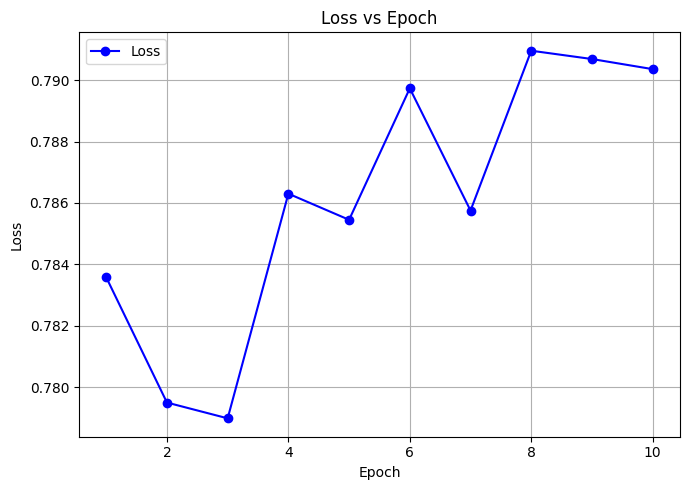

In [54]:
import matplotlib.pyplot as plt
avg_epoch_loss = torch.tensor(avg_epoch_loss, device =  'cpu')
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
model.eval()

GeoLocationModel(
  (base_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [57]:
avg_val_haversine_loss = 0.0
batch_haversine = []

model, optimizer, val_dataloader = accelerator.prepare(model, optimizer, val_dataloader)

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates, image_path in tqdm(val_dataloader, total=len(val_dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images, coordinates, image_path)
        loss_haversine = haversineLoss(outputs['pred'], coordinates).mean(dim=-1)
        batch_haversine.append(loss_haversine)
        avg_val_haversine_loss += loss_haversine

# Calculate average loss and haversine
avg_val_haversine_loss /= len(val_dataloader)

print(f'Validation Haversine Loss: {avg_val_haversine_loss:.4f}')

Validating: 100%|██████████| 313/313 [02:17<00:00,  2.27it/s]


Validation Haversine Loss: 0.7858


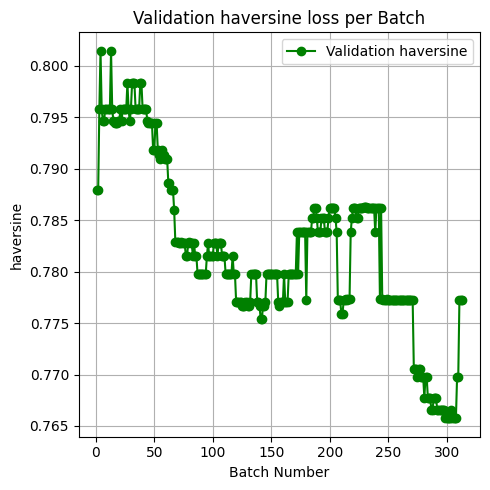

In [58]:
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# Back from gpu
batch_haversine = torch.tensor(batch_haversine, device =  'cpu')

# Remove outliers
batch_haversine = median_filter(batch_haversine, size=100)

plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, len(batch_haversine) + 1), batch_haversine, label='Validation haversine', color='green', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('haversine')
plt.title('Validation haversine loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [65]:
from global_land_mask import globe
import matplotlib.pyplot as plt
import random

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def plot_predictions(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for images, coordinates, image_path in dataloader:

            images = images.cuda()

            outputs = model(images, coordinates, image_path)

            images = images.cpu()
            coordinates = coordinates.cpu()
            outputs = outputs

            rand_index = random.sample(range(0, len(images) - 1), min(num_samples, len(images) - 1))

            for i in range(min(num_samples, len(images))):
                i = rand_index[i]

                pred_lat, pred_lon = outputs['pred'][i].cpu().numpy()
                true_lat, true_lon = coordinates[i].numpy()

                haver_err = haversineLoss(
                                      torch.tensor(np.array([[pred_lon, pred_lat]]), dtype=torch.float32).deg2rad(),
                                      torch.tensor(np.array([[true_lon, true_lat]]), dtype=torch.float32).deg2rad(),
                                      )
                # Display the image
                img = images[i]
                img = unnormalize(img).permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f'Pred: ({pred_lat:.4f}, {pred_lon:.4f})\nTrue: ({true_lat:.4f}, {true_lon:.4f})\n Haversine: {haver_err}')
                plt.axis('off')

                # World map for better understanding of how bad our prediction is
                geometry = [Point(pred_lon, pred_lat), Point(true_lon, true_lat)]
                geo_df = GeoDataFrame(geometry = geometry)
                world = gpd.read_file(url)
                geo_df.plot(ax=world.plot(color="lightgrey", figsize=(10, 6)), marker='x', c=['red', 'green'], markersize=50);

                plt.show()
            break

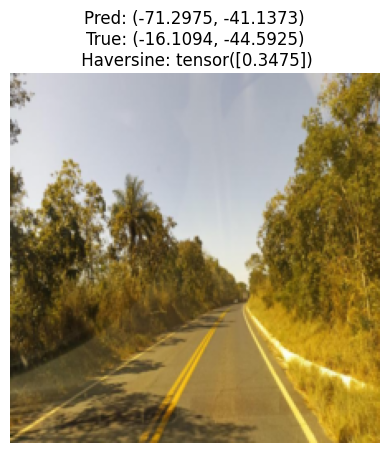

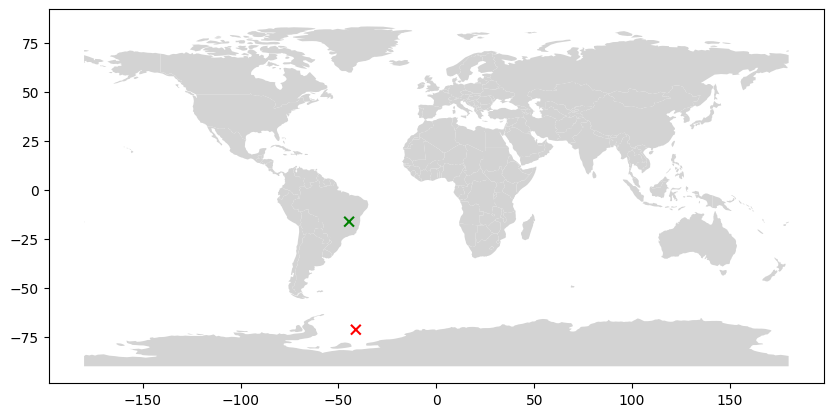

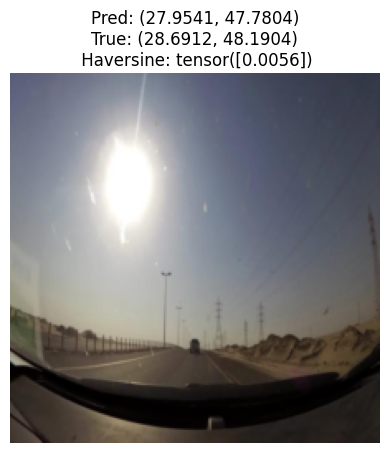

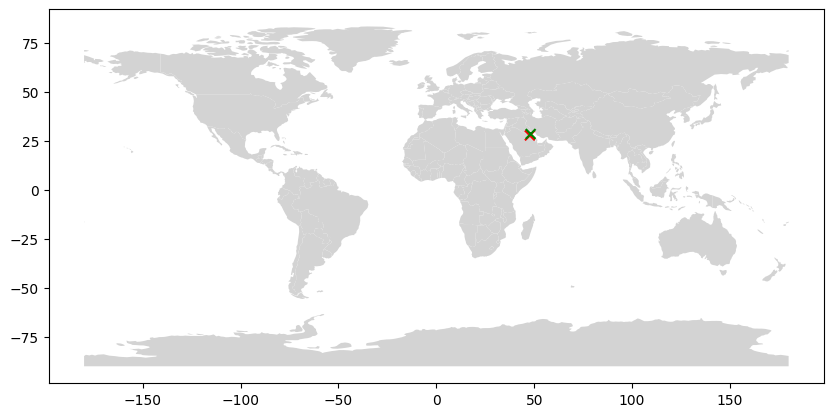

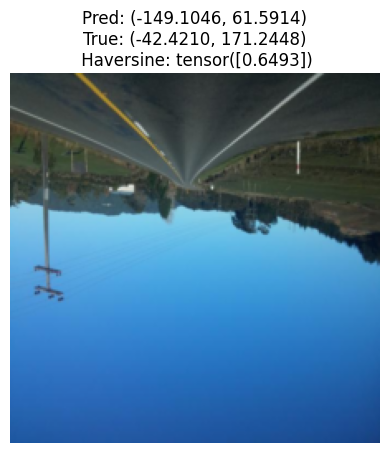

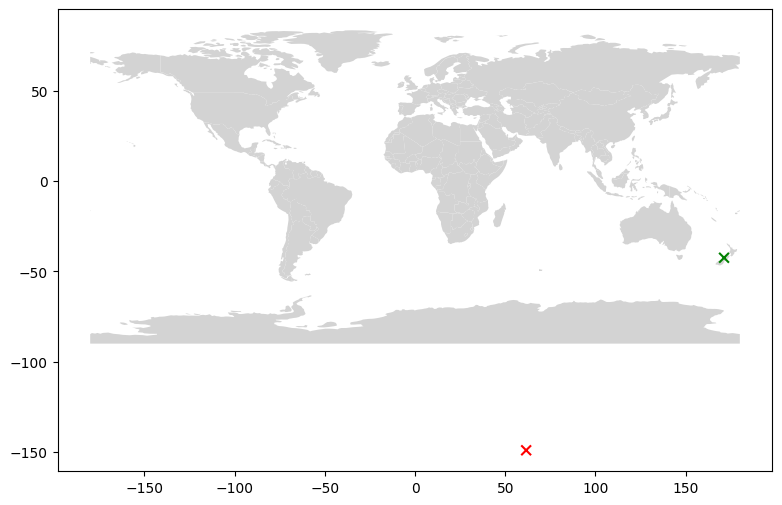

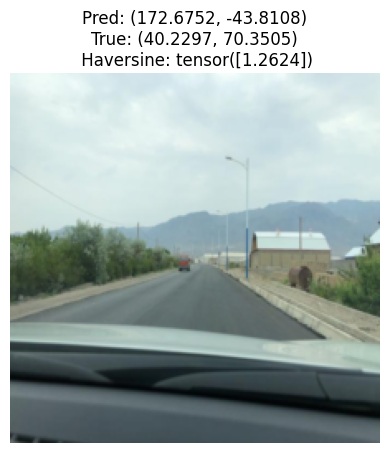

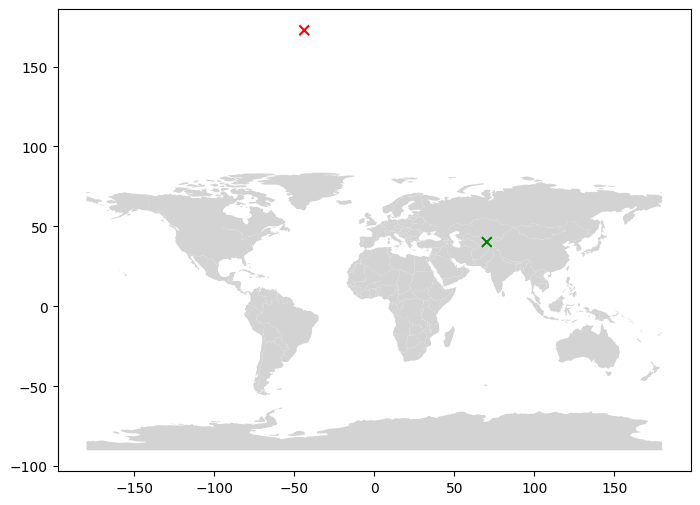

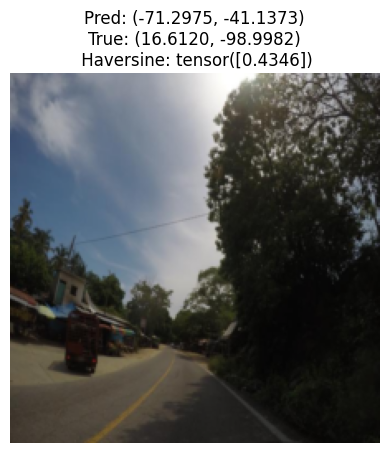

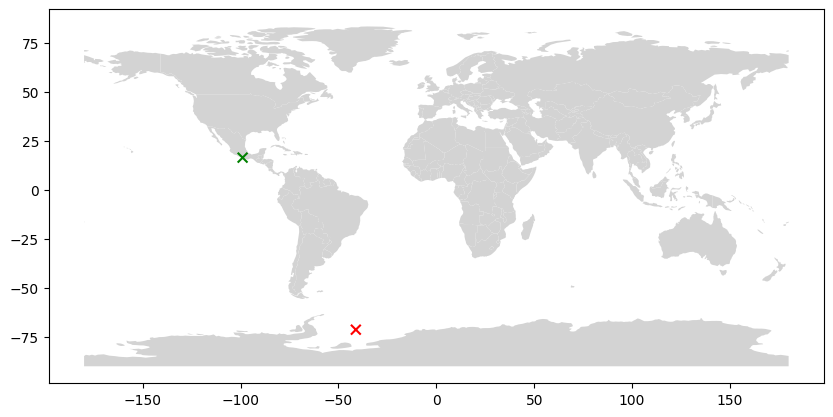

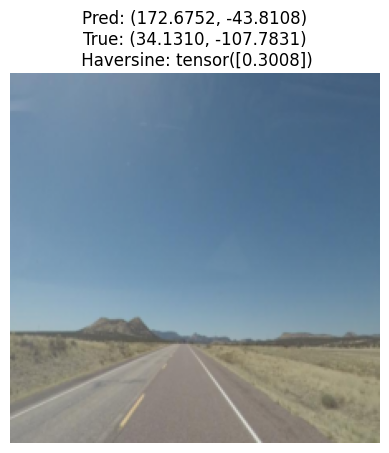

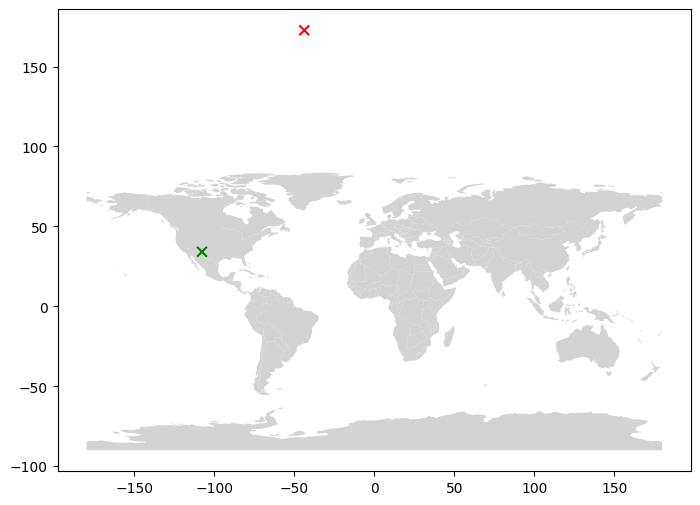

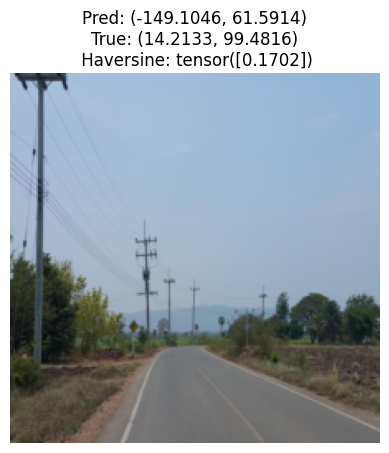

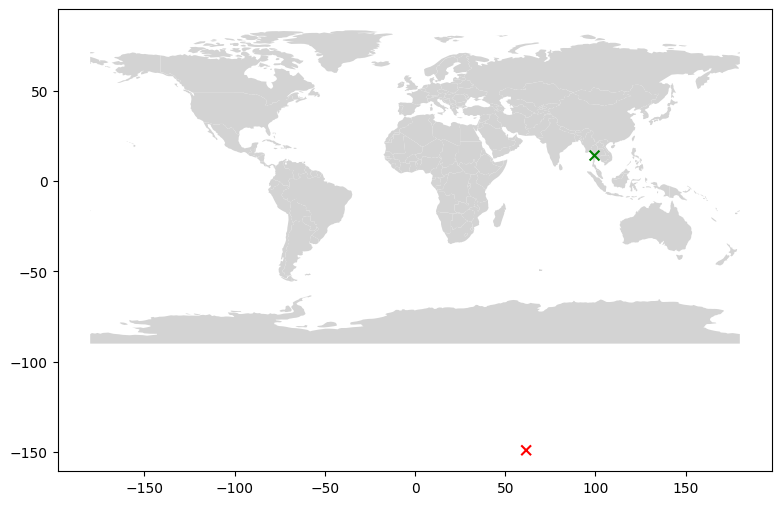

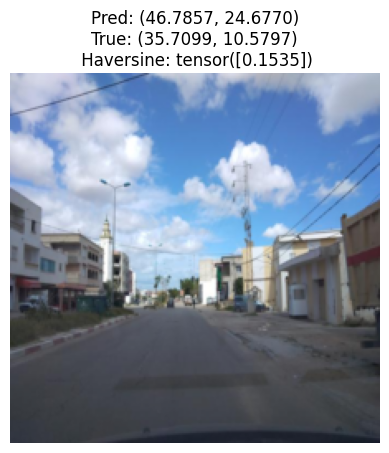

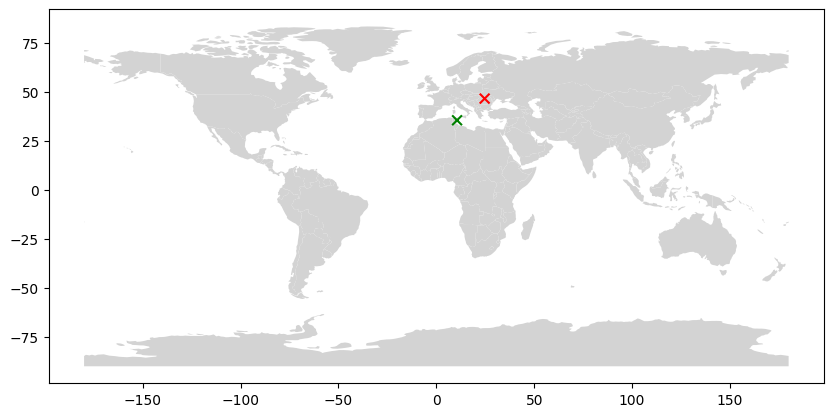

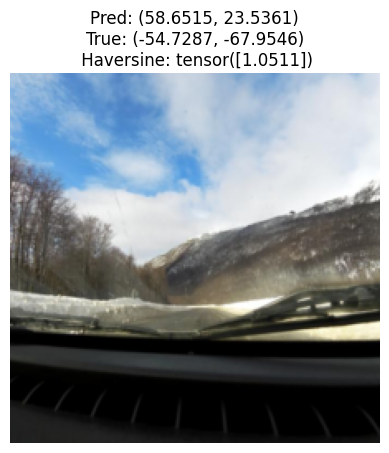

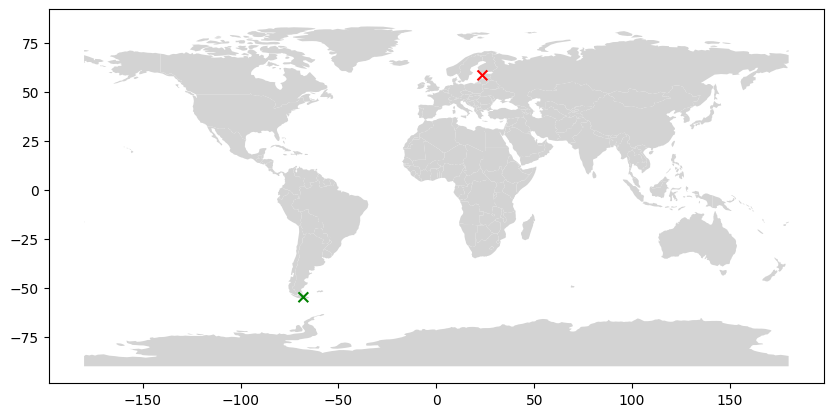

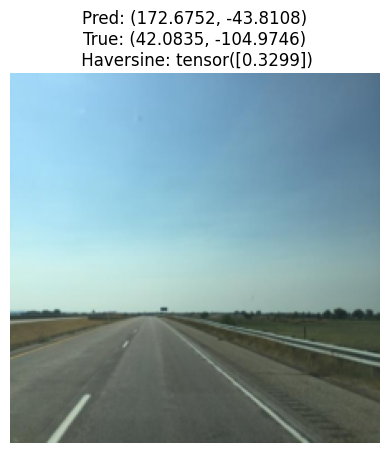

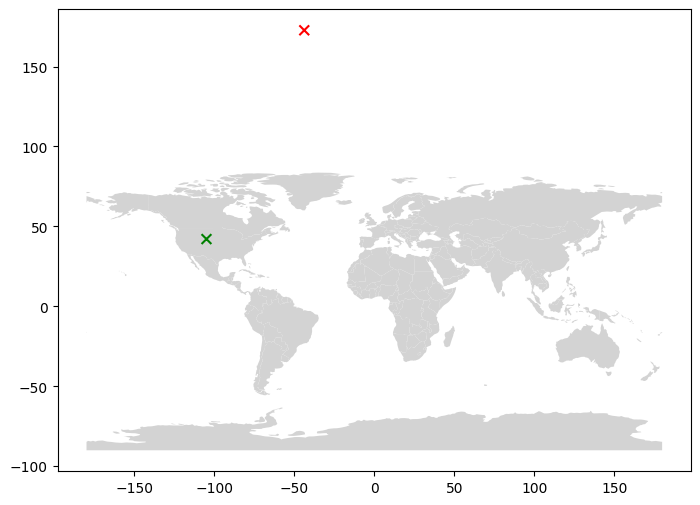

In [66]:
plot_predictions(model, val_dataloader, num_samples=10)